In [1]:
import torch

GPT_CONFIG_124M = {
    "vocab_size":50257,
    "context_length": 1024,
    "embd_dim": 768,
    "n_heads" : 12,
    "n_layers" : 12,
    "drop_rate" : 0.1,
    "qkv_bias" : False
}


In [4]:
import tiktoken 
import torch
import torch.nn as nn
tokenizer = tiktoken.get_encoding("gpt2")
text = "Every effort moves you"
text1 = "Every days hold a "
batch = []
batch.append(torch.tensor(tokenizer.encode(text)))
batch.append(torch.tensor(tokenizer.encode(text1)))

In [5]:
print(batch)

[tensor([6109, 3626, 6100,  345]), tensor([6109, 1528, 1745,  257,  220])]


In [6]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self,x):
         return 0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2.0 / torch.pi)) * (x + 0.044715 * torch.pow(x, 3))))


In [7]:
import matplotlib.pyplot as plt     

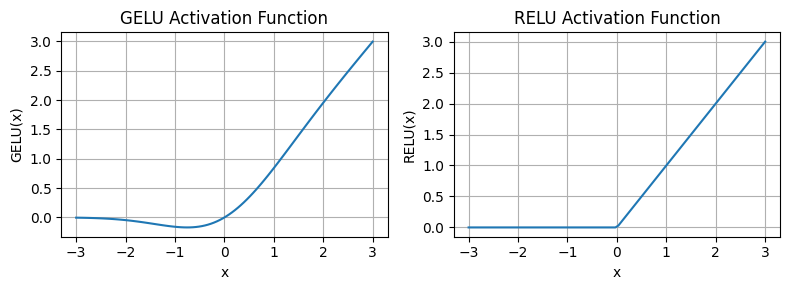

torch.nn.modules.activation.GELU

In [8]:
# Input tensor
x = torch.linspace(-3, 3, 100)
gelu, relu = GELU(), nn.ReLU()
# Compute activations
y_gelu, y_relu = gelu(x), relu(x)
plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "RELU"]), 1):
    plt.subplot(1, 2, i)  # Create subplot
    plt.plot(x,y)  # Plot x vs. q   
    plt.title(f"{label} Activation Function")  # Add title
    plt.xlabel("x")  # Label for x-axis
    plt.ylabel(f"{label}(x)")  # Label for y-axis
    plt.grid(True)  # Add grid

# Adjust layout and display
plt.tight_layout()
plt.show()
nn.GELU

In [33]:
class FeedForward(nn.Module):
    def __init__(self):
        super().__init__()

In [3]:
#Tokenization 
with open("verdict.txt",'r') as file:
    file = file.read()

print("Total no of characters", len (file))
file[:100]
#our goal is to tokenize 20479 characters 

Total no of characters 20479


'I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no g'

In [5]:
import re 
text = "Hello, How are you? My name is Ripesh Ghimire? Are you doinge well? Lets talk shall we "
result = re.split(r'(\s)',text)

In [7]:
preprocessed = re.split(r'([,.?_!"()\']|--|\s)', file)
preprocessed = [item.strip() for item in preprocessed if item.strip()]
print(len(preprocessed))

4649


In [11]:
#Now we convert the token into token id 
all_words = sorted(list(set(preprocessed)))
vocab_size = len(all_words)
print(vocab_size)

1159


In [18]:
#converting the given tokens into token-ids
vocab = {token:integer for integer,token in enumerate(all_words)}
vocab.items()

dict_items([('!', 0), ('"', 1), ("'", 2), ('(', 3), (')', 4), (',', 5), ('--', 6), ('.', 7), (':', 8), (';', 9), ('?', 10), ('A', 11), ('Ah', 12), ('Among', 13), ('And', 14), ('Are', 15), ('Arrt', 16), ('As', 17), ('At', 18), ('Be', 19), ('Begin', 20), ('Burlington', 21), ('But', 22), ('By', 23), ('Carlo', 24), ('Carlo;', 25), ('Chicago', 26), ('Claude', 27), ('Come', 28), ('Croft', 29), ('Destroyed', 30), ('Devonshire', 31), ('Don', 32), ('Dubarry', 33), ('Emperors', 34), ('Florence', 35), ('For', 36), ('Gallery', 37), ('Gideon', 38), ('Gisburn', 39), ('Gisburns', 40), ('Grafton', 41), ('Greek', 42), ('Grindle', 43), ('Grindle:', 44), ('Grindles', 45), ('HAD', 46), ('Had', 47), ('Hang', 48), ('Has', 49), ('He', 50), ('Her', 51), ('Hermia', 52), ('His', 53), ('How', 54), ('I', 55), ('If', 56), ('In', 57), ('It', 58), ('Jack', 59), ('Jove', 60), ('Just', 61), ('Lord', 62), ('Made', 63), ('Miss', 64), ('Money', 65), ('Monte', 66), ('Moon-dancers', 67), ('Mr', 68), ('Mrs', 69), ('My', 70)

In [19]:
class SimpleTokenizer:
    def __init__(self,vocab):
        self.str_to_int = vocab
        self.int_to_str = {i:s for s,i in vocab.items()}
    
    def encode(self,text):
        preprocessed = re.split(r'([,.?_!"()\']|--|\s)', text)
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        ids = [self.str_to_int[s] for s in preprocessed]
        return ids 
    def decode(self,ids):
        text = "".join([self.int_to_str[i]for i in ids])
        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text) #E
        return text

        

In [21]:
tokenizer = SimpleTokenizer(vocab)

In [ ]:
#adding special context tokens 
